Assume we want to observe the amplitudes A and B of an oscillation that relates to our observations in the form
$$y = A\sin(t) + B\cos(t)$$
Our instrument collects information every second, whereas only three readings are available. Those measurements refer to the full second, 2.5 ms before and 5ms before that particular epoch. The uncertainty of these three measurements is 0.25, 0.5 and 1.0 (in arbitray units). After taking the first measurements we want to update our estimates of $A$ and $B$ continiously by means of sequential least-squares adjustment.

In [9]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

# the true amplitudes of the sine and cosine terms are given here
A_true = 50
B_true = -25

#observation noise (see text above)
obsnoise1 = 1
obsnoise2 = 0.5
obsnoise3 = 0.25

#we can build the weight matrix with that info
P=inv(np.matrix([[obsnoise1*obsnoise1, 0, 0 ], [0, obsnoise2*obsnoise2, 0], [0, 0, obsnoise3*obsnoise3]]))

We define the Jacobian as

In [10]:
def GetJacobian(t):
    return np.matrix([[np.sin(t-0.005), np.cos(t-0.005)], [np.sin(t-0.0025), np.cos(t-0.0025)], [np.sin(t), np.cos(t)]])

And we create a function that provides us "measurements", including some Gaussian noise in accordance to the specifications above

In [11]:
def GetObs(t):
    return np.array([[A_true * np.sin(t-0.005) + B_true*np.cos(t-0.005)+obsnoise1*np.random.randn()], \
    [A_true * np.sin(t-0.0025) + B_true*np.cos(t-0.0025)+obsnoise2*np.random.randn()], \
    [A_true * np.sin(t) + B_true*np.cos(t)+obsnoise3*np.random.randn()]])

Let's start with the classical LSQ solution at the first epoch (t=0)

In [12]:
#some arrays which we use later for plotting
time_array=np.arange(0,121)
A_array=np.zeros(121) 
B_array=np.zeros(121) 
sigmaA=np.zeros(121) 
sigmaB=np.zeros(121) 


#LSQ @ t=0
A=GetJacobian(0)
y=GetObs(0)
x=inv(np.transpose(A)@P@A)@np.transpose(A)@P@y
s02=np.asscalar(np.transpose(y)@P@y/(3-2))
Sxx=s02*inv(np.transpose(A)@P@A)

#store the results in the first array element
time_array[0]=0
A_array[0]=x[0]
B_array[0]=x[1]
sigmaA[0]=np.sqrt(Sxx[0,0])
sigmaB[0]=np.sqrt(Sxx[1,1])

Now we are ready to run the sequential least-squares method over an observation period of 120 seconds (2 minutes)

In [13]:
for t in np.arange(1,121):
    #storing the "old" states and variances
    x_old=x
    s02_old=s02
    Sxx_old=Sxx
    
    #processing the observations at t_k
    A=GetJacobian(t)
    y=GetObs(t)
    x=x_old + inv(s02_old * inv(Sxx_old) + np.transpose(A)@P@A)@np.transpose(A)@P@(y-A@x_old)
    dx=x-x_old
    epsi=y-A@x
    s02 = np.asscalar(1.0/((t+1)*3.0-2.0)*( s02_old * (t*3-2 + np.transpose(dx)@inv(Sxx_old)@dx) + np.transpose(epsi)@P@epsi))
    Sxx=s02*inv(s02_old*inv(Sxx_old) + np.transpose(A)@P@A)
    
    #storing the solution in the array which we will later use for plotting
    time_array[t]=t
    A_array[t]=x[0]
    B_array[t]=x[1]
    sigmaA[t]=np.sqrt(Sxx[0,0])
    sigmaB[t]=np.sqrt(Sxx[1,1])
    

Now we can plot the time evolutions of both, out parameters $A$ and $B$ as well as their formal errros.

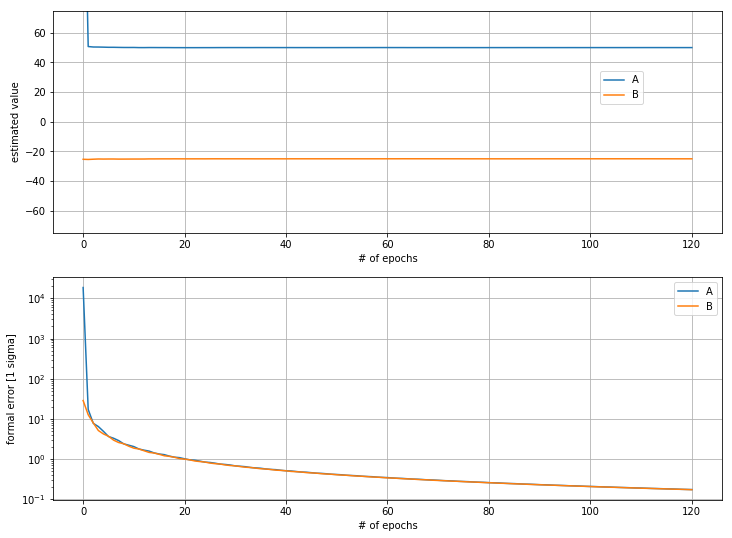

In [14]:
plt.figure(1,figsize=(12, 9))
ax=plt.subplot(211)    
plt.plot(time_array, A_array,label='A')
plt.plot(time_array, B_array,label='B')
ax.legend(loc='upper center', bbox_to_anchor=(0.85, 0.75))
axes = plt.gca()
axes.set_ylim([-75,75])
plt.grid()
plt.xlabel('# of epochs')
plt.ylabel('estimated value')
plt.subplot(212)  
plt.semilogy(time_array, sigmaA,label='A')
plt.semilogy(time_array, sigmaB,label='B')
plt.legend()
plt.grid()
plt.xlabel('# of epochs')
plt.ylabel('formal error [1 sigma]')
plt.show()

What we see is that not only the values of $A$ and $B$ come closer to their "true" values as we collect more observations, but also the formal errors shrink continuously. While this example demonstrates that we can easily perform sequential least-square solutions, it also shows us the large restrications we suffer from this, namely that the parameters need to be constant over time in order to make the algorithm work.